In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
pd.options.mode.chained_assignment = None  # default='warn'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
#Import the international football dataset to a new dataframe called matches
matches = pd.read_csv('csv/results.csv')

#Getting a quick sense for the dataset by looking at the first 5 and last 5 rows
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [5]:
matches.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
43446,2022-05-28,India,Jordan,0,2,Friendly,Doha,Qatar,True
43447,2022-05-28,Mexico,Nigeria,2,1,Friendly,Arlington,United States,True
43448,2022-05-29,United Arab Emirates,Gambia,1,1,Friendly,Dubai,United Arab Emirates,False
43449,2022-05-30,Ethiopia,Lesotho,1,1,Friendly,Adama,Ethiopia,False
43450,2022-05-31,Thailand,Bahrain,1,2,Friendly,Pathum Thani,Thailand,False


In [6]:
#This dataset contains some matches that have not yet played, so I'm going to remove those next.
completed_matches = matches.dropna()
#confirm that every other match has a score (should all be 0)
print('NAs')
print(completed_matches.isna().sum(), "\n")
#check for duplicates
print('Duplicates:',completed_matches.duplicated().sum())

NAs
date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64 

Duplicates: 0


In [7]:
#Sweet, one final look at the dataset in aggregate now to see if there's anything else that is unexpected
print(completed_matches.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43451 entries, 0 to 43450
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        43451 non-null  object
 1   home_team   43451 non-null  object
 2   away_team   43451 non-null  object
 3   home_score  43451 non-null  int64 
 4   away_score  43451 non-null  int64 
 5   tournament  43451 non-null  object
 6   city        43451 non-null  object
 7   country     43451 non-null  object
 8   neutral     43451 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 3.0+ MB
None


In [8]:
#that's a lot of games. I'm curious when these games happened.

#first I want to create a column of the year, month, and date of each game to group by later

completed_matches[['year','month','day']] = completed_matches['date'].str.split("-", expand = True).rename(columns = {0 : 'year', 1 : 'month', 2 : 'day'})
completed_matches['year'] = completed_matches['year'].astype(dtype = int)

completed_matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,day
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,11,30
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873,03,08
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,03,07
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875,03,06
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,03,04


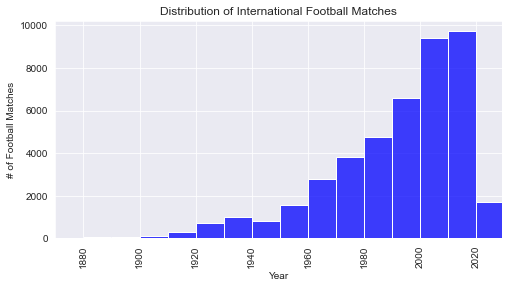

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (8,4))

sns.set_style('darkgrid')

G = sns.histplot(data = completed_matches, x = 'year', binwidth = 10, binrange = (1870,2022), legend = False, color = 'blue')

G.set(xlabel = 'Year',
     ylabel = '# of Football Matches')

plt.xlim(1870,2029)

plt.xticks(rotation = 90)

plt.title('Distribution of International Football Matches')

plt.show()

Each bin constitutes a decade (XXX0 - XXX9). At first glance, growth (in terms of games per decade) first accelerated in the 1960's and again in the 2000's, before leveling off in the 2010s.

This brings up an initial exploratory question to build off of - what is driving this growth?

- Are teams playing more games?
- Are there more teams playing?
- Or some combination of above?

In [10]:
#The dataset isn't tidy for an analysis of total games played by each country (team) for each year, 
#because there is a home and away column (two teams per record). So the first step to determining what is driving growth is to 
#create a dataset where each team has a row for each game they play, whether or not they are home/away.

from collections import defaultdict

#create a dictionary with index = year of match and value = list of unique teams playing that year
countries_by_year = defaultdict(list)

for index, row in completed_matches.iterrows() :
    if row['year'] not in countries_by_year.keys():
        countries_by_year[row['year']] = []
        
for index, row in completed_matches.iterrows() :
    if row['home_team'] not in countries_by_year[row['year']]:
        countries_by_year[row['year']].append(row['home_team'])  
    if row['away_team'] not in countries_by_year[row['year']]:
        countries_by_year[row['year']].append(row['away_team'])
        
#create a series where the index is the match year and the column values are the count of teams playing that year
        
index = []
team_count = []

for key in countries_by_year:
    index.append(key)
    team_count.append(len(countries_by_year[key]))
    
annual_country_counts = pd.Series(data = team_count, index = index)

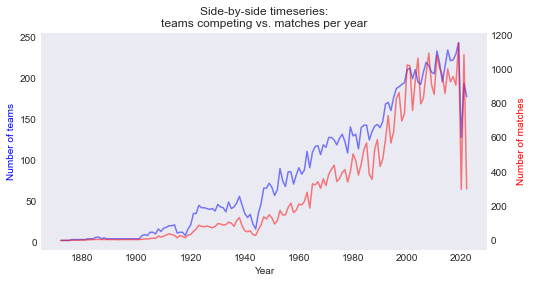

In [11]:
#convert the series into a dataframe to make plotting with Seaborn simpler and to add in the match count data
team_count_df = pd.DataFrame(data = team_count, index = index).rename(columns = {0 : 'teams'})
team_count_df['matches'] = completed_matches.groupby('year')['date'].count()

###
plt.style.use('seaborn-dark')

fig, ax = plt.subplots(figsize = (8,4))

ax.plot(team_count_df.index, team_count_df['teams'],color = 'blue', alpha = 0.5, label = 'teams')
ax.set_xlabel('Year')
ax.set_ylabel('Number of teams', color = 'blue')

ax2 = ax.twinx()

ax2.plot(team_count_df.index, team_count_df['matches'],color = 'red', alpha = 0.5, label = 'matches')
ax2.set_ylabel('Number of matches', color = 'red')

plt.title('Side-by-side timeseries:\nteams competing vs. matches per year')

plt.show()

In [12]:
completed_matches

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,day
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,11,30
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873,03,08
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,03,07
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875,03,06
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,03,04
...,...,...,...,...,...,...,...,...,...,...,...,...
43446,2022-05-28,India,Jordan,0,2,Friendly,Doha,Qatar,True,2022,05,28
43447,2022-05-28,Mexico,Nigeria,2,1,Friendly,Arlington,United States,True,2022,05,28
43448,2022-05-29,United Arab Emirates,Gambia,1,1,Friendly,Dubai,United Arab Emirates,False,2022,05,29
43449,2022-05-30,Ethiopia,Lesotho,1,1,Friendly,Adama,Ethiopia,False,2022,05,30


In [14]:
team_count_df

,teams,matches
1872,2,1
1873,2,1
1874,2,1
1875,2,1
1876,3,2
...,...,...
2018,230,908
2019,244,1156
2020,128,299
2021,194,1086


In [20]:
bel_home = matches[matches.home_team == "Belarus" ]
bel_away = matches[matches.away_team == "Belarus"]

In [21]:
bel_home

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
1156,1928-08-17,Belarus,Switzerland,6,3,Friendly,Moscow,Soviet Union,True
1157,1928-08-19,Belarus,Ukraine,2,6,Friendly,Moscow,Soviet Union,True
1160,1928-08-22,Belarus,Finland,1,2,Friendly,Moscow,Soviet Union,True
4005,1956-08-03,Belarus,Kyrgyzstan,1,0,Friendly,Moscow,Soviet Union,True
6572,1967-06-04,Belarus,Mexico,2,1,Friendly,Minsk,Soviet Union,False
...,...,...,...,...,...,...,...,...,...
42720,2021-09-05,Belarus,Wales,2,3,FIFA World Cup qualification,Kazan,Russia,True
42783,2021-09-08,Belarus,Belgium,0,1,FIFA World Cup qualification,Kazan,Russia,True
42901,2021-10-11,Belarus,Czech Republic,0,2,FIFA World Cup qualification,Kazan,Russia,True
43069,2021-11-16,Belarus,Jordan,1,0,Friendly,Minsk,Belarus,False


In [22]:
bel_home

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
1156,1928-08-17,Belarus,Switzerland,6,3,Friendly,Moscow,Soviet Union,True
1157,1928-08-19,Belarus,Ukraine,2,6,Friendly,Moscow,Soviet Union,True
1160,1928-08-22,Belarus,Finland,1,2,Friendly,Moscow,Soviet Union,True
4005,1956-08-03,Belarus,Kyrgyzstan,1,0,Friendly,Moscow,Soviet Union,True
6572,1967-06-04,Belarus,Mexico,2,1,Friendly,Minsk,Soviet Union,False
...,...,...,...,...,...,...,...,...,...
42720,2021-09-05,Belarus,Wales,2,3,FIFA World Cup qualification,Kazan,Russia,True
42783,2021-09-08,Belarus,Belgium,0,1,FIFA World Cup qualification,Kazan,Russia,True
42901,2021-10-11,Belarus,Czech Republic,0,2,FIFA World Cup qualification,Kazan,Russia,True
43069,2021-11-16,Belarus,Jordan,1,0,Friendly,Minsk,Belarus,False


In [23]:
bel_away

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
4010,1956-08-09,Russia,Belarus,5,1,Friendly,Moscow,Soviet Union,False
4013,1956-08-11,Russia,Belarus,4,2,Friendly,Moscow,Soviet Union,False
11075,1979-07-28,Russia,Belarus,0,0,Friendly,Moscow,Soviet Union,False
17583,1993-01-27,Ecuador,Belarus,1,1,Friendly,Guayaquil,Ecuador,False
17589,1993-01-30,Peru,Belarus,1,1,Friendly,Lima,Peru,False
...,...,...,...,...,...,...,...,...,...
42224,2021-03-30,Belgium,Belarus,8,0,FIFA World Cup qualification,Leuven,Belgium,False
42668,2021-09-02,Czech Republic,Belarus,1,0,FIFA World Cup qualification,Ostrava,Czech Republic,False
42839,2021-10-08,Estonia,Belarus,2,0,FIFA World Cup qualification,Tallinn,Estonia,False
43031,2021-11-13,Wales,Belarus,5,1,FIFA World Cup qualification,Cardiff,Wales,False
